**Import**

In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')

!pip install transformers
!pip install -U datasets

from collections import defaultdict, Counter
import json
import torch

from matplotlib import pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset, DatasetDict
from torch.utils.data import DataLoader

Mounted at /content/gdrive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cu

In [ ]:
banktrak_df = pd.read_csv('/content/gdrive/MyDrive/Group 1: DSSI Summer 2025/Data/summary_banktrak.csv')
#banktrak_df_1 = pd.read_csv('/content/gdrive/MyDrive/Group 1: DSSI Summer 2025/Data/banktrak-8K-20230501-annotated.csv')
#banktrak_df.head(10)
model_path = "/content/gdrive/MyDrive/DSSI/distilbert-model"

1. USING SAMPLERS FOR CLASS IMBALANCE

In [ ]:
# #https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html#imblearn.over_sampling.RandomOverSampler
# from imblearn.over_sampling import RandomOverSampler

# X = banktrak_df_1[['text']]
# y = banktrak_df_1[['contains_debt_instrument_information']]

# #oversampling minority data
# ros = RandomOverSampler(random_state=42)                 #this is the random oversampling
# X_resampled, y_resampled = ros.fit_resample(X, y)        #i think this is fitting our model with the undersampling
# y_resampled.contains_debt_instrument_information.value_counts()

# X_resampled = X_resampled.reset_index(drop=True)
# y_resampled = y_resampled.reset_index(drop=True)

# banktrak_df = pd.concat([X_resampled, y_resampled], axis=1)

In [ ]:
# #https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html
# from imblearn.under_sampling import RandomUnderSampler

# X = banktrak_df_1[['text']]
# y = banktrak_df_1[['contains_debt_instrument_information']]

# #oversampling minority data
# rus = RandomUnderSampler(random_state=42)                 #this is the random oversampling
# X_resampled, y_resampled = rus.fit_resample(X, y)        #i think this is fitting our model with the undersampling
# y_resampled.contains_debt_instrument_information.value_counts()

# X_resampled = X_resampled.reset_index(drop=True)
# y_resampled = y_resampled.reset_index(drop=True)

# banktrak_df = pd.concat([X_resampled, y_resampled], axis=1)

2. SPLIT INTO TRAINING AND VALIDATION THEN TURNING INTO DICTIONARY



In [ ]:
#spliting train and val
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(banktrak_df, test_size=0.2, random_state=42) #validation size is 20%, random state is just there for reproducilbility

# turn to json dict
from datasets import Dataset, DatasetDict
dataset = DatasetDict({'train': Dataset.from_pandas(train_df), 'validation': Dataset.from_pandas(val_df)}) #use dataset dict to turn to dataframe to dict

3. Loading the model & tokenizer in

In [ ]:
# load tokenizer
from transformers import AutoTokenizer, AutoModelForMaskedLM #import auto tokenizer, and auto model

tokenizer = AutoTokenizer.from_pretrained("german-nlp-group/electra-base-german-uncased") #import tokenizer
model = AutoModelForMaskedLM.from_pretrained("german-nlp-group/electra-base-german-uncased") #import model

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/103 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of ElectraForMaskedLM were not initialized from the model checkpoint at german-nlp-group/electra-base-german-uncased and are newly initialized: ['generator_lm_head.bias', 'generator_predictions.LayerNorm.bias', 'generator_predictions.LayerNorm.weight', 'generator_predictions.dense.bias', 'generator_predictions.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tensor([[    2,  2566, 27179,  1774,  3142, 19367,   805,  5437,  2757,  2558,
          1770, 17346, 26228,  3448,   780,     3]])


**Dataset Preprocessing**

In [ ]:
# apply tokenizer to dataset
tokenized_dataset = dataset.map(lambda example: tokenizer(example['text'], padding="max_length", truncation=True, max_length=64))

# clean tokenizer
#tokenized_dataset = tokenized_dataset.remove_columns(['item', 'text', 'company','cik'])
tokenized_dataset = tokenized_dataset.rename_column("contains_debt_instrument_information", "labels") #rename this column labels bz the model likes that
tokenized_dataset.set_format("torch")
#turn to pytorch tensor for model

Map:   0%|          | 0/164 [00:00<?, ? examples/s]

Map:   0%|          | 0/44 [00:00<?, ? examples/s]

**Using DataLoader to batchify data**

In [ ]:
#split to train and eval dataset
train_dataset = tokenized_dataset['train'].shuffle(seed=1111)  #changed the range to have all the data
eval_dataset = tokenized_dataset['validation']

#apply dataloader to datasets
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=8, shuffle=False)

**Training and Validation**

In [ ]:
from transformers import get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
from transformers import set_seed
from torch.optim import AdamW

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#choosing device

#model = DistilBertForSequenceClassification.from_pretrained(name, num_labels=2).to(device)
model = AutoModelForSequenceClassification.from_pretrained("german-nlp-group/electra-base-german-uncased", num_labels=2).to(device)
num_epochs = 1
num_training_steps = len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=0.01) #2e-5 to 5e-5
#used pytourch import to set parameters for better model
#optimizer to run backpropagation

lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
#scheduler that sets a protocol for parameter updates at the end of a batch

# labels = labels.long()
best_val_loss = float("inf") # starts at infilty so any real loss will be smaller
progress_bar = tqdm(range(num_training_steps))
#tqdm tracks iteration status

for epoch in range(num_epochs): #for num of epochs
    # training
    model.train() # training mode
    training_losses = [] #store batch losses
    for batch_i, batch in enumerate(train_dataloader): #for batches in training loader

        optimizer.zero_grad()

        # copy input to device
        input_ids = batch['input_ids'].to(device)            #moves these to same device
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        labels= labels.long()


        # Call the model for Forward Pass
        output = model(input_ids = input_ids, attention_mask = attention_mask, labels =labels)
        training_loss = output.loss                                           #takes loss data
        training_losses.append(training_loss.item())                          #adds loss data

        #Do backprop and update params by taking an optimization step
        training_loss.backward()                                              #bakc progration graidnet
        optimizer.step()
        lr_scheduler.step()                                                   #pdates learning rate according to scheduler policy (linear decay here)
        progress_bar.update(1)                                                #advances the tqdm progress bar by 1 step (one batch done)
    print("Mean Training Loss", np.mean(training_losses))

    # validation
    val_loss = 0
    #set to evaluation mode because we dont want to collect gradients
    model.eval()            #disables things like dropout and layer norm randomness
    for batch_i, batch in enumerate(eval_dataloader):                  #go over batches
        with torch.no_grad():                                          #clear gradients
            # copy input to device
            input_ids = batch['input_ids'].to(device)                  #add to device
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            labels = labels.long()

            #call the model again for Forward Pass
            output = model(input_ids = input_ids, attention_mask = attention_mask, labels =labels)

        # add the batch average of validation loss to the running sum
        val_loss += output.loss               # batch’s loss to the total validation loss.

    # calculating average validation loss across all batches
    avg_val_loss = val_loss / len(eval_dataloader)                               #calculations of best loss
    print(f"Validation loss: {avg_val_loss}")

    # Saving this model checkpoint only if the current validation loss
    # is better than the best validation loss obtained so far
    if avg_val_loss < best_val_loss:
        print("Saving checkpoint!")
        best_val_loss = avg_val_loss
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(),'val_loss': best_val_loss,}, f"{model_path}epoch_{epoch}.pt")
    print()

print(f"The best validation loss after {num_epochs} epochs is: {best_val_loss}")

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at german-nlp-group/electra-base-german-uncased and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/21 [00:00<?, ?it/s]

Mean Training Loss 0.6321772251810346
Validation loss: 0.5470395088195801
Saving checkpoint!

The best validation loss after 1 epochs is: 0.5470395088195801


**Evaluate your model on Test Data**

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

eval_dataloader = DataLoader(tokenized_dataset['validation'], batch_size=len(tokenized_dataset['validation']))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()            #evalaution mode
test_batch_logits = []    #store models raw outputs logits
y_true = []
for batch_i, batch in enumerate(eval_dataloader): #go through batches
    with torch.no_grad():                          #clear graidnet
        # copy input to device
        input_ids = batch['input_ids'].to(device)            #add to deviice
        attention_mask = batch['attention_mask'].to(device)  #add device
        labels = batch['labels'].cpu().detach().numpy()      #removes labels

        # Call the model on test data
        output = model(input_ids = input_ids, attention_mask = attention_mask, labels =None) #labels none becuase didnt pass any
        test_batch_logits.append(output.logits)                #append output logits --stores logits before soft max
        y_true.extend(labels)                                  #add ground turth labels

print(len(test_batch_logits),len(eval_dataloader))      #shape of the final logits tensor ([num_examples, num_classes])
test_logits = torch.cat(test_batch_logits, dim=0)     #concatenates the logits from all batches along dimension 0.

#sanity check -> dimension 0 of your logits tensor should be same as the size of the test dataset
print(test_logits.shape,len(tokenized_dataset['validation']),len(y_true))

1 1
torch.Size([44, 2]) 44 44


In [ ]:
#Convert the logits to predicted labels
y_pred = torch.argmax(test_logits, dim = 1).cpu().numpy()

print(y_true[:10])
print(y_pred[:10])

#sanity check: should have as many predictions as labels
assert len(y_pred)==len(y_true)

[np.False_, np.True_, np.True_, np.True_, np.True_, np.True_, np.False_, np.False_, np.True_, np.True_]
[0 1 1 1 0 1 1 0 1 1]


In [ ]:
# call the f1_score function
print('F1 Score:',f1_score(y_true, y_pred, average='binary')) #why add average binary?

# call the accuracy_score function
print('Accuracy Score:',accuracy_score(y_true, y_pred))

F1 Score: 0.8666666666666667
Accuracy Score: 0.8181818181818182


new stuff

Confusion Matrix:
 [[10  6]
 [ 2 26]]


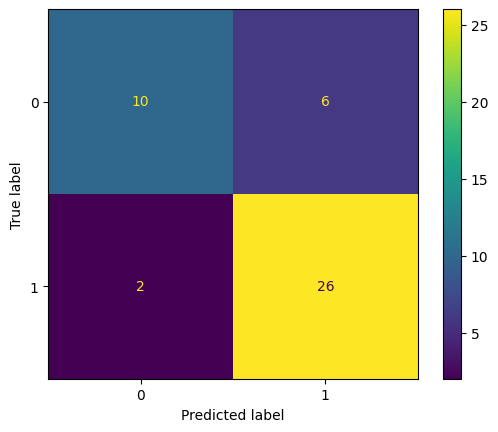

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# pip install transformer-ranker

In [ ]:
# from datasets import load_dataset
# from transformer_ranker import TransformerRanker, prepare_popular_models

# # Step 1: Load the CoNLL-03 dataset from HuggingFace
# dataset = load_dataset('conll2003')

# # Step 2: Use our list of 17 'base' LMs as candidates
# language_models = prepare_popular_models('base')

# # Step 3: Initialize the ranker with the dataset
# ranker = TransformerRanker(dataset, dataset_downsample=0.2)

# # ... and run the ranker to obtain the ranking
# results = ranker.run(language_models, batch_size=64)

# # print the ranking
# print(results)